# Problema - 3

J0 si J1 dau cu banul pentru a decide cine incepe

1. se arunca cu propriul zar, fie n numarul obtinut
2. se arunca de 2*n ori cu propria moneda, fie m numarul de steme obtinut

if n > m castiga 1 else 2

J1 probability pentru stema = 4/7 -> 3/7 pentru cap

J0 are D0 si S0
J1 are D1 si S1

C -> cine incepe jocul
P(C=j0) = 1/2
P(C=j1) = 1/2

n = 1,2,3,4,5,6
P(D0=n) = 1/6 
P(D1=n) = 1/6

J0 incepe.
P(stema)=4/7
S0∼Binomial(2D0,4/7).

J1 incepe.
P(stema)=1/2
S1∼Binomial(2D1,1/2)

J0 castiga daca D0 >= S0
J1 castiga daca D0 < S0

J1 castiga daca D1 >= S1
J0 castiga daca D1 < S1

In [29]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

model = BayesianNetwork([
    ('MonedaInițială', 'ZarJucător'),
    ('MonedaInițială', 'NumărSteme'),
    ('ZarJucător', 'NumărSteme'),
    ('MonedaInițială', 'Câștigător'),
    ('ZarJucător', 'Câștigător'),
    ('NumărSteme', 'Câștigător')
    ])

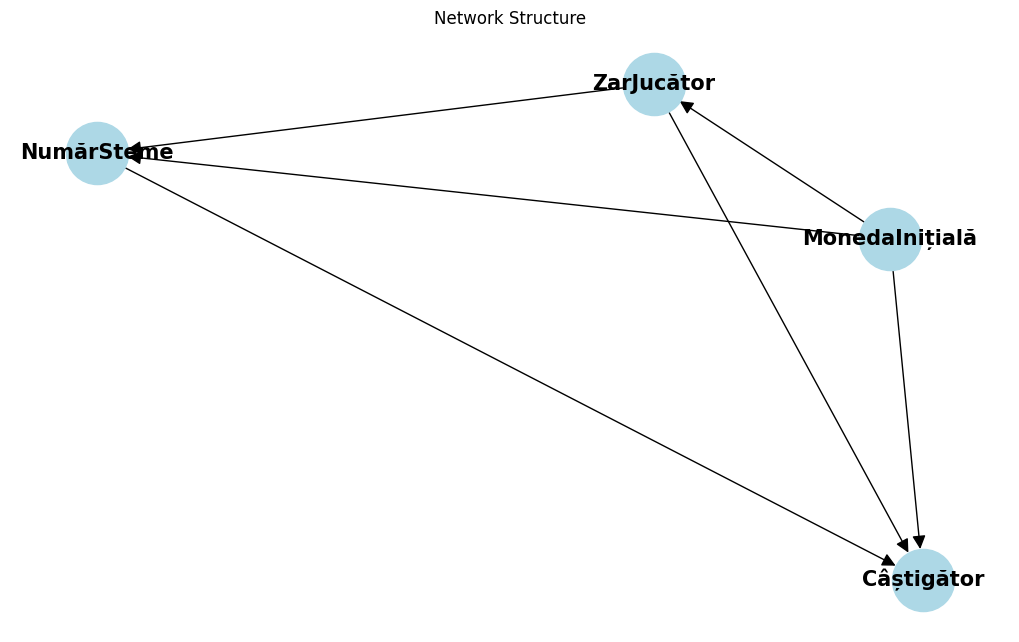

In [30]:
import matplotlib.pyplot as plt
import networkx as nx

graph = nx.DiGraph()
graph.add_edges_from(model.edges())

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(graph) 
nx.draw(graph, pos, with_labels=True, arrows=True, node_size=2000, node_color='lightblue', font_size=15, font_weight='bold', arrowsize=20)

plt.title('Network Structure')
plt.show()

In [31]:
cpd_m0 = TabularCPD(variable='MonedaInițială', variable_card=2, 
                    values=[[0.5], [0.5]],
                    state_names={'MonedaInițială': ['J0', 'J1']})

cpd_z = TabularCPD(variable='ZarJucător', variable_card=6, 
                    values=[[1/6, 1/6],
                            [1/6, 1/6],
                            [1/6, 1/6],
                            [1/6, 1/6],
                            [1/6, 1/6],
                            [1/6, 1/6]],
                    evidence=['MonedaInițială'], evidence_card=[2],
                    state_names={'ZarJucător': [1, 2, 3, 4, 5, 6], 
                                    'MonedaInițială': ['J0', 'J1']})

model.add_cpds(cpd_m0, cpd_z)


In [33]:
import numpy as np
from pgmpy.factors.discrete import TabularCPD
from scipy.stats import binom

def prob_steme_j0(n):
    return [binom.pmf(k, 2 * n, 0.5) for k in range(2 * n + 1)]

def prob_steme_j1(n):
    return [binom.pmf(k, 2 * n, 4 / 7) for k in range(2 * n + 1)]

values_steme = []

for z in range(1, 7):
    probs_j0 = prob_steme_j0(z)
    row_j0 = probs_j0 + [0] * (13 - len(probs_j0))
    values_steme.append(row_j0)
    
    probs_j1 = prob_steme_j1(z)
    row_j1 = probs_j1 + [0] * (13 - len(probs_j1))
    values_steme.append(row_j1)

values_steme = np.array(values_steme)


cpd_s = TabularCPD(variable='NumărSteme', variable_card=13,
                    values=values_steme.T,
                    evidence=['MonedaInițială', 'ZarJucător'],
                    evidence_card=[2, 6],
                    state_names={'NumărSteme': list(range(13)),
                                    'MonedaInițială': ['J0', 'J1'],
                                    'ZarJucător': [1, 2, 3, 4, 5, 6]})

model.add_cpds(cpd_s)


In [38]:
values_castigator = []

for moneda_initiala in ['J0', 'J1']:
    for zar in range(1, 7):
        row = []
        for steme in range(13):
            if zar >= steme:
                if moneda_initiala == 'J0':
                    row.append([1, 0])
                else:
                    row.append([0, 1])
            else: 
                if moneda_initiala == 'J0':
                    row.append([0, 1])
                else:
                    row.append([1, 0])
        values_castigator.append(row)

values_castigator = np.array(values_castigator).reshape(2 * 6, 13, 2)


cpd_castigator = TabularCPD(variable='Câștigător', variable_card=2,
                            values=values_castigator.reshape(2, -1),
                            evidence=['MonedaInițială', 'ZarJucător', 'NumărSteme'],
                            evidence_card=[2, 6, 13],
                            state_names={'Câștigător': ['J0', 'J1'],
                                        'MonedaInițială': ['J0', 'J1'],
                                        'ZarJucător': [1, 2, 3, 4, 5, 6],
                                        'NumărSteme': list(range(13))})

model.add_cpds(cpd_castigator)

In [40]:
model.check_model()
infer = VariableElimination(model)

In [49]:
prob_j0_wins = infer.query(variables=['Câștigător'])
print(prob_j0_wins)

+----------------+-------------------+
| Câștigător     |   phi(Câștigător) |
+================+===================+
| Câștigător(J0) |            0.5009 |
+----------------+-------------------+
| Câștigător(J1) |            0.4991 |
+----------------+-------------------+
